In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial A3: DeepLIFT/SHAP

Although machine learning models -- and, more specifically, deep learning models -- are frequently referred to as "black box" and "uninterpretable", these models can be invaluable tools for discovery. At a high level, if one rephrases the problem not of understanding what the set/s of learned weights mean but rather how changes in each <i>input</i> to the model affect the <i>output</i> of the model, principled methods can be devised. These methods aim to attribute to each feature in an example a value that corresponds in some meaningful manner to that feature's "importance" to the predictions for that feature. The simplest such value is just the Euclidean distance between the predictions before and after making the substitution. Frequently, this value is then Z-score normalized independently for each position in the sequence. In genomics, each feature is a nucleotide at a position so there are `4*seq_len` total features. Each attribution method has its own set of assumptions and interpretation of the output so it is important to fully understand the method being used.

Perhaps the most conceptually simple attribution method is in silico saturation mutagenesis (ISM). In this method, each potential substitution is considered and the attribution value is derived from the difference in prediction before and after making the substitution. Nucleotides that drive predictions higher, such as those within protein binding sites, are usually assigned a higher score and those that are irrelevant for the prediction are assigned near-zero values. Importantly, this method measures the individual effect that each nucleotide has on predictions and does not consider epistatic interactions. You can read more about it in the corresponding tutorial.

A challenge with ISM is that it requires `3*seq_len` forward passes through the model; in contrast, gradient-based methods work by assigning an importance to each feature simultaneously based on the gradient with respect to an output. Put another way, perturbation-based methods require a number of forward passes proportional to the number of perturbations/inputs, whereas gradient-based methods require a number of backward passes proportional to the number of outputs of the model. If you have a model with a single output this means that you can calculate attributions for each input with a single backward pass. If you have a multi-task model with many tasks you will need one backward pass for each task that you care about.

Unfortunately, basic gradient-based/saliency methods are unstable and suffer from not having a reference to compare against. Imagine if you were trying to run ISM but did not have an original sequence to compare the predictions to. DeepLIFT provides a "rescale" correction for the instability of gradients and also calculates the gradient <i>with respect to a reference sequence</i>. The choice of reference sequence is critical for getting meaningful attributions but, fortunately, generating such references in genomics is fairly straightforward. DeepSHAP, which was developed concurrently, extends this idea to using multiple reference sequences and averaging over them. They are commonly called DeepLIFT/SHAP to recognize the connections between methods and concurrence of development.

tangermeme provides an implementation of DeepLIFT/SHAP that is based on the implementation found in Captum. However, this implementation has several advantages: (1) it is significantly more compact and better documented, (2) it is unit tested thoroughly to ensure convergence (see below) of common layers and models, (3) it allows vectorized calculations of attributions when the references are different for each sequence, (4) it automatically checks the convergence of each run and raises a warning if convergence is not reached, and (5) it can calculate attributions for models even when the full number of references do not fit in memory by running batches that do fit in memory and then aggregating the references after they have all been run. 

Let's take a look at how to do this using the Beluga model. We start by loading it up like normal.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

Now, let's take a random one-hot encoding and put an AP-1 motif right in the middle.

In [3]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

X = random_one_hot((1, 4, 2000)).type(torch.float32)
X = substitute(X, "GTGACTCATC")

Now we can run DeepLIFT/SHAP using the Beluga model focusing specifically on a task that predicts JunD binding in GM12878. The signature of DeepLIFT/SHAP somewhat mirrors that of the `predict` function with the notable changes being that an optional `target` parameter allows you to focus on a specific output and the `random_state` argument allows you to force DeepLIFT/SHAP to be deterministic when generating the randomly shuffled sequences as references.

In [4]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = deep_lift_shap(model, X, target=267, device='cpu', random_state=0)
X_attr.shape

torch.Size([1, 4, 2000])

We will get back a tensor that is the same shape as the input where the values are the attributions averaged across all references. As a technical note, these values are not the multipliers that are usually returned by other DeepLIFT/SHAP implementations. Rather, these are the multipliers after they have been corrected for the difference-from-reference property. Specifically, the multipliers can be thought of as the importance of each character to the prediction. But, using a one-hot encoding, multiple values cannot be 1 and so the presence of a 1 explicitly means that the other values at that position are 0. So, the true influence of a character at a position is the attribution of that character at that position minus the attribution taken by the character at the reference sequence. 

Here, `tangermeme` makes several decisions for the user, which diverges from my goal of being as assumption-free as possible. However, this is because calculating attributions correctly is challenging but there is a well-used way to do it and I wanted to make sure that people -- particularly those new to genomics -- were doing it right.

Anyway, we can visualize these attributions using a logo where the height of the characters corresponds to the attribution values.

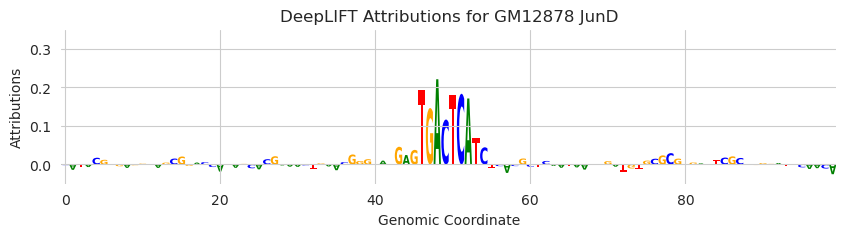

In [5]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 JunD")
plt.ylim(-0.05, 0.35)
plt.show()

This looks good. When we substitute in an AP-1 motif that Beluga is known to respond to, the attributions highlight the motif and are pretty low everywhere else.

We can check and see that there are other tasks where this motif does not drive predictions. Specifically, we can find the binding of some very different protein in the same cell type and make sure that the attributions are low.

IMPORTANT: when comparing attributions at the same location across different tasks it is crucial that they must be done against the exact same reference sequences. When you set `random_state` to an integer and use the the same number of shuffles this is taken care for you. But if you do not set a random state you will get slightly different attributions for even the same task.

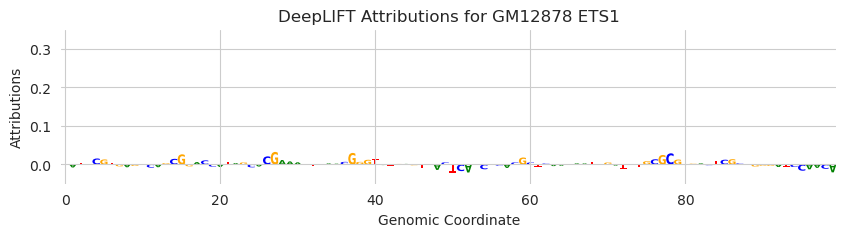

In [6]:
X_attr = deep_lift_shap(model, X, target=214, device='cpu',random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 ETS1")
plt.ylim(-0.05, 0.35)
plt.show()

Looks good. This result shows that the inclusion of an AP-1 binding site does not drive predictions of ETS1.

Conversely, we can show that tasks that should be influenced by the inclusion of an AP-1 binding site also highlight the added motif. Specifically, because most AP-1 factors also drive chromatin accessibility we can look at a DNase target in the same cell type.

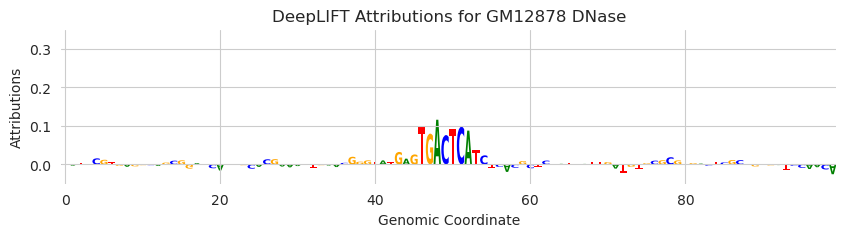

In [7]:
X_attr = deep_lift_shap(model, X, target=55, device='cpu',random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 DNase")
plt.ylim(-0.05, 0.35)
plt.show()

DeepLIFT/SHAP is most useful because it can identify all the motifs that are driving model predictions in a region -- not just a single one. To demonstrate this, we will insert two copies of the AP-1 motif as well as two other non-informative sequences.

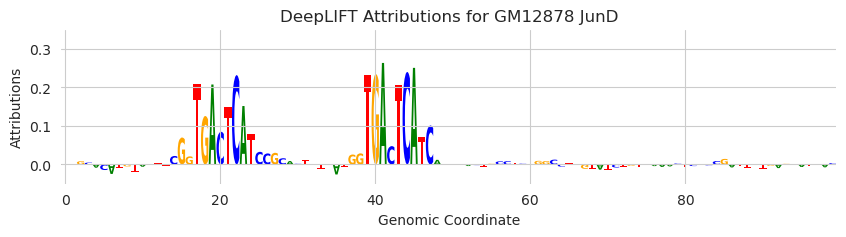

In [8]:
from tangermeme.ersatz import multisubstitute

X = random_one_hot((1, 4, 2000)).type(torch.float32)
X = multisubstitute(X, ["GTGACTCATC", "GTGACTCATC", "CCTCTG", "AACTCTCC"], [12, 8, 15])
X_attr = deep_lift_shap(model, X, target=267, random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 JunD")
plt.ylim(-0.05, 0.35)
plt.show()

As you might expect, the attributions highlight the two AP-1 motifs and are low for the other two sequences.

#### Large Model Handling

Working with massive models like Enformer can be challenging due to their large memory footprint. When making predictions, large memory requirements can be circumvented by simply setting a batch size to a small number or even just 1. Running DeepLIFT/SHAP is a bit more challenging because a number of references need to be operated on and averaged over for each example and this number of references should, ideally, be larger the larger the length of the sequence. Some implementations require that an example and all reference examples are able to fit in memory at the same time so that even when the batch size is set to 1 that still requires fitting in `2*n_shuffles` sequences in memory where `n_shuffles` is the number of reference sequences used (multiplied by 2 because, in practice, the example being explained needs to be copied once for each reference because you're calculating differences from reference internally). 

The `tangermeme` implementation of DeepLIFT/SHAP overcomes this issue by having the batch size correspond to the number of example-reference pairs being processed at the same time. So, when `batch_size=1`, two sequences are being put in memory: the example and one of the references for that sequence. Batches of example-reference pairs are then processed with each batch being moved to the specified device and the results being moved back to the CPU. After each batch, if an example and all of its references have been processed, the average across all references is taken. Basically, this implementation allows one to run DeepLIFT/SHAP with a number of references larger than what fits in GPU memory.

We can see here what the attributions look like when setting the batch size to less than the number of shuffles.

In [9]:
X_attr = deep_lift_shap(model, X, target=267, n_shuffles=20, device='cpu', batch_size=1, random_state=0)
X_attr[0, :, :10]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,
          5.6139e-06,  2.4708e-05, -8.2555e-06,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  4.2981e-06,  0.0000e+00,  3.3393e-05,
         -0.0000e+00,  0.0000e+00, -0.0000e+00, -7.3389e-05,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -8.8689e-05],
        [-0.0000e+00, -3.2803e-06, -0.0000e+00,  1.4074e-05, -0.0000e+00,
         -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00]])

.. and we can see what they look like when the batch size is equal to the number of shuffles, meaning that only one batch is processed.

In [10]:
X_attr = deep_lift_shap(model, X, target=267, n_shuffles=20, device='cpu', batch_size=20, random_state=0)
X_attr[0, :, :10]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,
          5.6139e-06,  2.4708e-05, -8.2555e-06,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  4.2981e-06,  0.0000e+00,  3.3393e-05,
         -0.0000e+00,  0.0000e+00, -0.0000e+00, -7.3389e-05,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -8.8689e-05],
        [-0.0000e+00, -3.2803e-06, -0.0000e+00,  1.4074e-05, -0.0000e+00,
         -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00]])

The results are the same! So, if you're using a massive model you can still run a reasonable number of references without being limited by only having modest hardware. 

#### References

The choice of reference is hugely important for getting intuitive results. Ideally, a reference should be a biologically plausible sequence that is not predicted to have the activity that you care about. In `tangermeme`, the default reference function is `dinucleotide_shuffle`. Dinucleotide shuffles are reasonable choices because they preserve GC dinucleotide content -- important due to their role in being methylated -- while being disruptive to any motifs present in the sequence.

Let's take a look at what happens when we increase the number of shuffles used when analyzing the sequence with multiple motifs substituted into it.

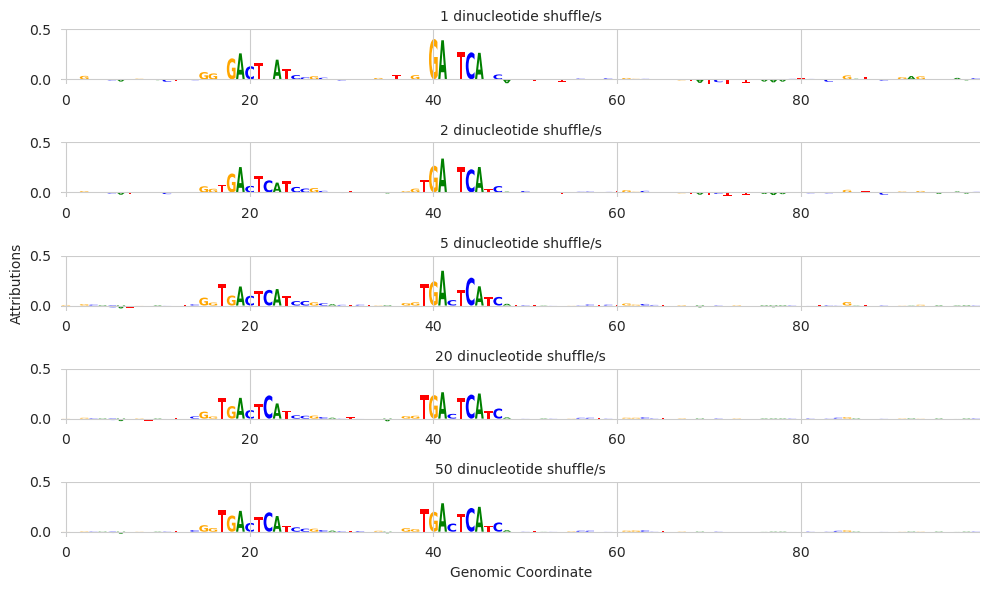

In [11]:
X_attr1 = deep_lift_shap(model, X, target=267, device='cpu', n_shuffles=1, random_state=0)
X_attr2 = deep_lift_shap(model, X, target=267, device='cpu', n_shuffles=2, random_state=0)
X_attr5 = deep_lift_shap(model, X, target=267, device='cpu', n_shuffles=5, random_state=0)
X_attr20 = deep_lift_shap(model, X, target=267, device='cpu', n_shuffles=20, random_state=0)
X_attr50 = deep_lift_shap(model, X, target=267, device='cpu', n_shuffles=50, random_state=0)

plt.figure(figsize=(10, 6))
for i, X_attr in enumerate([X_attr1, X_attr2, X_attr5, X_attr20, X_attr50]):
    ax = plt.subplot(5, 1, i+1)
    plot_logo(X_attr[0, :, 950:1050], ax=ax)

    plt.title("{} dinucleotide shuffle/s".format([1, 2, 5, 20, 50][i]), fontsize=10)
    plt.ylim(-0.05, 0.5)
    
    if i == 2:
        plt.ylabel("Attributions")
    if i == 4:
        plt.xlabel("Genomic Coordinate")
    

plt.tight_layout()
plt.show()

As the number of references increase we can see that the two motif instances start to mirror each other more, and that the effect of additional shuffles seems to diminish as more are done. So, it is important to make sure that you are using a large enough number of sequences that the attributions have stabilized.

Something worth noting is that when only one reference sequence is used, some positions -- even multiple within the second motif instance -- appear to have a zero value. This is because, due to DeepLIFT/SHAP's difference-from-reference nature, whenever the reference sequence has the same character as the original sequence the attribution is definitionally zero. When using multiple shuffles this effect is averaged out, but it is worth keeping this property in mind.

But, dinucleotide shuffles are not the only reference-generation algorithm that can be used. The `references` parameter can be any function (default `ersatz.dinucleotide_shuffle`) that takes in a batch of sequences, a number of shuffles, and an integer seed for controlling random state, and returns a tensor with shape `(n_examples, n_references, len(alphabet), length)`. As a simple example, we can pass in a function that just returns all zeroes.

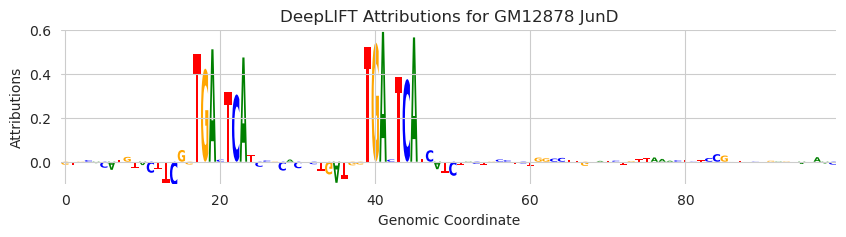

In [12]:
zeros = lambda X, n, random_state: torch.zeros(X.shape[0], n, *X.shape[1:])
X_attr = deep_lift_shap(model, X, target=267, references=zeros, device='cpu', n_shuffles=1, random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 JunD")
plt.ylim(-0.1, 0.6)
plt.show()

The all-zeroes reference and its friend, the uniform reference (either 0.25 or 0.5 everywhere), have been proposed as an alternative to dinucleotide shuffling. These may be reasonable baselines in some cases. I do not think we actually know what the best reference is, in part because there is not really a clear way to evaluate references.

Finally, if you have preconstructed references and want to just pass in a tensor instead of a function you can do that.

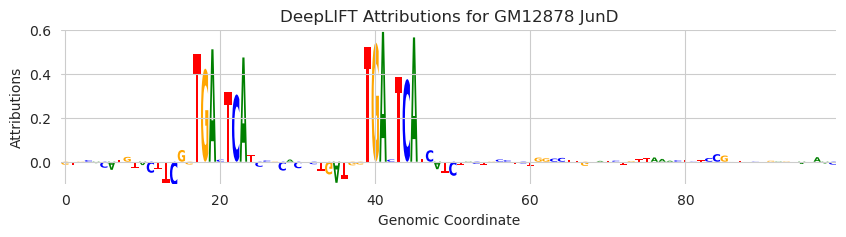

In [13]:
zeros = torch.zeros(X.shape[0], 1, *X.shape[1:])
X_attr = deep_lift_shap(model, X, target=267, references=zeros, device='cpu', n_shuffles=1, random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 JunD")
plt.ylim(-0.1, 0.6)
plt.show()

Being able to use custom references gives you a large amount of flexibility when it comes to do subtle analyses. For example, imagine that you know a large portion of the sequence is not relevant for your analysis. You can hold that portion of the sequence constant and make the shuffles you do more meaningful in the area that you do care about (remember that the number of permutations increases exponentially with the number of positions you are shuffling). Here, we can focus on the left AP-1 motif substitution.

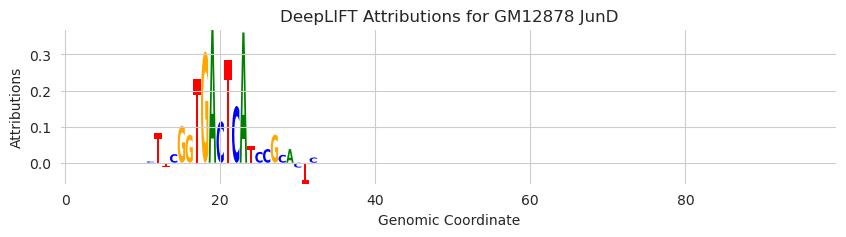

In [14]:
from tangermeme.ersatz import dinucleotide_shuffle

ref = dinucleotide_shuffle(X, n=20, start=960, end=985, random_state=0)
X_attr = deep_lift_shap(model, X, target=267, device='cpu', references=ref, random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for GM12878 JunD")
plt.show()

Remember that DeepLIFT/SHAP use references and that you are explaining the <i>difference from reference</i>. If the references are uniformly identical to the example being explained because, for example, you only shuffled a portion of the sequence to construct the references, the attributions must definitionally be zero where you did not shuffle. This means you should not use the attribution values (which will be zero) in the non-shuffled portions of the sequence and that the attributions in the shuffled portion of the sequence refer to the additional increase in model prediction from just the shuffled portion.

#### Convergence Deltas

A key property of the DeepLIFT/SHAP algorithm is that the sum of attributions is equal to the difference in predictions between the original sequence and the reference sequence. However, there can be challenges with implementing DeepLIFT/SHAP correctly or ensuring that every layer in a neural network is being handled correctly. For example, max pooling layers require special care due to the maximum operation. If you mistakenly have dropout turned on the algorithm will not work.

Accordingly, one can check the "convergence deltas" to see whether the algorithm is working correctly. Importantly (and somewhat confusingly), DeepLIFT/SHAP is not an iterative algorithm and so "convergence" does not mean the same thing here as it does during training. What these measure is the difference between (the sum of the attributions) and the (difference in predictions between the original sequence and reference sequence). Parentheses added to make the sentence more comprehendable given two uses of the word "difference." These two quantities <i>should</i> be equal and so when they are not something has gone wrong.

You can have the convergence deltas printed for each example-reference pair (one print statement per batch) using the `print_convergence_deltas` parameter.

In [15]:
X_attr = deep_lift_shap(model, X, target=267, device='cpu', random_state=0, print_convergence_deltas=True)

tensor([2.3842e-07, 4.7684e-07, 2.3842e-07, 2.3842e-07, 4.7684e-07, 4.7684e-07,
        4.7684e-07, 2.3842e-07, 4.7684e-07, 4.7684e-07, 1.1921e-06, 4.7684e-07,
        1.1921e-06, 4.7684e-07, 9.5367e-07, 4.7684e-07, 2.3842e-07, 2.3842e-07,
        7.1526e-07, 1.1921e-06], grad_fn=<AbsBackward0>)


These values seem reasonable. Usually, you would expect to see values in the range of around machine precision. However, there are two caveats to this statement. The first is that machine precision on a GPU seems to be lower than on a CPU. I do not know exactly why this is, but across several algorithms the difference of numbers that should be equal is around 1e-6 to 1e-8 on a CPU and around 1e-4 to 1e-5 on a GPU. A second caveat is that some layers, such as max pooling/unpooling operations in CUDNN, do not have deterministic implementations even when explicitly setting the use of deterministic algorithms in PyTorch. I would recommend reading https://pytorch.org/docs/stable/notes/randomness.html 

In general, *the convergence deltas should be small w.r.t the predictions*. If you are getting a convergence delta in the range of ~1e-4 and predictions are above 0.1 that means the delta is three orders of magnitude smaller than the predictions and likely not too significant. If your convergence deltas are 1e-5 but the predictions are also in that range, that is likely a bigger problem.

Anyway, let's take a look at what happens when we run the same thing on a GPU.

In [16]:
X_attr = deep_lift_shap(model, X, target=267, random_state=0, print_convergence_deltas=True)

tensor([2.4080e-05, 1.0657e-04, 1.9288e-04, 4.7278e-04, 1.8740e-04, 1.5259e-04,
        3.2091e-04, 2.3675e-04, 5.2857e-04, 4.6015e-05, 1.5044e-04, 1.0705e-04,
        5.5075e-05, 3.9053e-04, 4.7612e-04, 1.5640e-04, 7.3910e-05, 7.5817e-05,
        3.0828e-04, 2.6321e-04], device='cuda:0', grad_fn=<AbsBackward0>)


Looks like we are getting convergence deltas in the range that I mentioned you would see on a GPU if everything was fine. In practice, if you are concerned that there may be a bug with your model -- either because of an undiagnosed bug in the algorithm somewhere or a layer in the model has not yet been registered -- you should try running the model on a small number of examples on the CPU to see whether the deltas get much smaller. 

Running Beluga on the GPU does demonstrate that this implementation of DeepLIFT/SHAP will raise a non-terminating warning when the convergence deltas get too high. These is useful for automatically knowing that everything is fine. 

#### Additional Non-Linear Operations

A critical part of DeepLIFT/SHAP working (and having low convergence deltas) is knowing what to do when it encounters each type of layer in the model. Specifically, for linear layers nothing needs to be done, and for non-linear layers the "rescale" rule needs to be applied. The way the rescale rule is implemented changes between activation functions and max-pooling layers (because the maximum operation and the pooling operation yield very different implementation strategies from an element-wise non-linearity) and potentially other forms of layers that exist.

In `tangermeme` there is an internal dictionary mapping operations to how the rescale rule is implemented. If the operation is not in the dictionary the implementation assumes that it is a linear layer and nothing needs to be done. If you want to add additional operations or override how currently-implemented layers are handled you can pass in a dictionary of `additional_nonlinear_ops`. Each key should be the class type and the value should be the function that should be applied. To demonstrate how to do this, let's try overriding the ReLU non-linearity operation with just doing nothing instead of rescaling the gradient.

In [17]:
_nonlinear = lambda x, grad_input, grad_output: grad_input
additional_nonlinear_ops = {torch.nn.ReLU: _nonlinear}

X_attr = deep_lift_shap(model, X, target=267, additional_nonlinear_ops=additional_nonlinear_ops, random_state=0, 
    print_convergence_deltas=True)

tensor([10.4793, 11.5042,  3.3573,  8.9456,  2.0517, 10.3768,  4.9426,  6.8905,
         5.2843, 12.0783,  2.2528,  4.5493,  9.3421,  2.6807,  1.8102,  6.6792,
         6.8412,  3.7978,  7.0050,  8.7039], device='cuda:0',
       grad_fn=<AbsBackward0>)


/users/jmschr/github/tangermeme/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([10.4793, 11.5042,  3.3573,  8.9456,  2.0517, 10.3768,  4.9426,  6.8905,
         5.2843, 12.0783,  2.2528,  4.5493,  9.3421,  2.6807,  1.8102,  6.6792,
         6.8412,  3.7978,  7.0050,  8.7039], device='cuda:0',
       grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +


As you might expect, replacing the real rescaling operation with doing nothing causes massive convergence deltas. Extending this idea, if you are getting large convergence deltas it is possible that there are non-linear operations in your model that are not in the dictionary. Not all activation functions or pooling layers are currently supported. Most activation functions will be covered by the built-in `_nonlinear` function (not the one above, the one in `tangermeme.deep_lift_shap`) so if you are using a custom activation you should first try using that.

#### Comparison with Other Tools

As a sanity check we can confirm that this implementation of DeepLIFT/SHAP matches other implementations. See the vignette "Attribution Trickiness and DeepLiftShap Implementations" for a thorough discussion of comparisons across implementations.